<a href="https://colab.research.google.com/github/greatermonk/Denoising-Diffusion-Model/blob/main/Diffusion_Model(cifar_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries**

**install tensorflow by typing "pip install tensorflow" in command prompt**

**install matplotlib by typing "pip install matplotlib" in command prompt**

In [24]:
import math
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.layers import Lambda
from keras.datasets import cifar10
from keras.optimizers.experimental import AdamW
import numpy as np
from matplotlib import pyplot as plt
import keras.losses
import keras.callbacks
from keras.models import clone_model
from keras.metrics import Mean

# DEFINE HYPERPARAMTERS(CONSTANTS)


In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 32
NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20
#Optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

# Load and preprocess the data


In [3]:
def preprocess(imgs):
    img = tf.cast(imgs, tf.float32) / 255.0
    return img

#load the data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

test_images = preprocess(test_images)
train_images = preprocess(train_images)

170498071/170498071 [==============================] - 14s 0us/step


# display sample images




In [4]:

def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")
    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")
    plt.show()

# Define Diffusion Schedule
i)**Linear Diffusion Schedule:**- In a linear diffusion schedule, the variance of the noise added to the data increases linearly over time.

ii)**Cosine diffusion schedule**:- A cosine diffusion schedule uses a cosine function to modulate the variance of the noise over time.

iii)**Offset Cosine diffusion schedule**:- An offset cosine diffusion schedule is a variant where the cosine function is shifted or offset to adjust the starting point of the noise variance.

In [5]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

#Define Cosine diffusion schedule
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2) #Smoothly transitions from 1 to 0 (since cos(90) = 0) over the diffusion steps.
    noise_rates = tf.sin(diffusion_times * math.pi / 2)  #Smoothly transitions from 0 to 1 (since sin(90) = 1) over the diffusion steps.
    return noise_rates, signal_rates

#Also define offset cosine diffusion schedule
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.94
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)
    return noise_rates, signal_rates

**Plot the diffusion schedules**

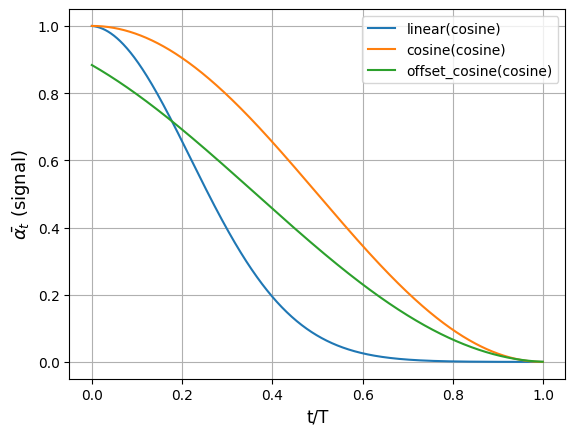

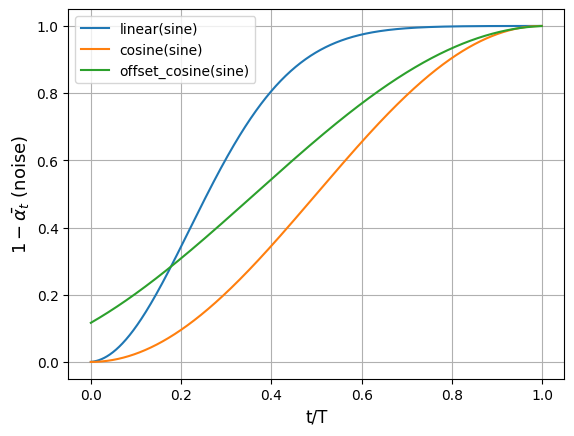

In [6]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(diffusion_times)
offset_cosine_noise_rates, offset_cosine_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

plt.plot(diffusion_times, linear_signal_rates ** 2, linewidth=1.5, label = "linear(cosine)")
plt.plot(diffusion_times, cosine_signal_rates ** 2, linewidth=1.5, label = "cosine(cosine)")
plt.plot(diffusion_times, offset_cosine_signal_rates ** 2, linewidth=1.5, label = "offset_cosine(cosine)")
plt.xlabel("t/T", fontsize = 12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize = 13)
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(diffusion_times, linear_noise_rates ** 2, linewidth=1.5, label = "linear(sine)")
plt.plot(diffusion_times, cosine_noise_rates ** 2, linewidth=1.5, label = "cosine(sine)")
plt.plot(diffusion_times, offset_cosine_noise_rates ** 2, linewidth=1.5, label = "offset_cosine(sine)")
plt.xlabel("t/T", fontsize = 12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize = 13)
plt.legend()
plt.grid(True)
plt.show()


# Sinusoidal Embedding
sinusoidal embedding is used to represent time steps as continuous values. By encoding each time step using sine and cosine functions of different frequencies, the model can effectively capture temporal information and handle the sequential nature of the diffusion process.

In [7]:
def sinusoidal_embeddings(x):
    frequencies = tf.exp(tf.linspace(tf.math.log(1.0), tf.math.log(1000.0), NOISE_EMBEDDING_SIZE // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=-1)
    return embeddings

**Plot sinusoidal embeddings**

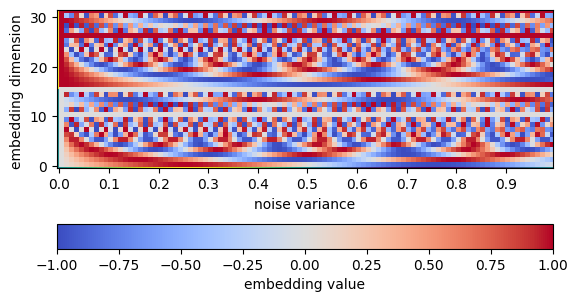

In [8]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embeddings(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(np.arange(0, 100, 10), labels = np.round(np.arange(0.0, 1.0, 0.1), 1))
ax.set_xlabel("noise variance", fontsize = 10)
ax.set_ylabel("embedding dimension ", fontsize = 10)
plt.pcolor(embedding_array, cmap = 'coolwarm')
plt.colorbar(orientation = "horizontal", label = "embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

# Unet Blocks
i)Residual Block

ii)Down block

iii)Up-Block

In [9]:
def residual_block(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = Conv2D(width, kernel_size=1)(x)
        x = BatchNormalization(center=False, scale=False)(x)
        x = Conv2D(width, 3, padding="same", activation="swish")(x)
        x =  Conv2D(width, 3, padding="same")(x)
        x = Add()([x, residual])
        return x
    return apply


def down_block(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = residual_block(width)(x)
            skips.append(x)
        x = AveragePooling2D(pool_size=2)(x)
        return x
    return apply


def up_block(width, block_depth):
    def apply(x):
        x, skips = x
        x = UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = Concatenate()([x, skips.pop()])
            x = residual_block(width)(x)
        return x
    return apply

# Define the Unet architecture

In [10]:
noisy_images = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, 1)(noisy_images)

noise_variances = Input(shape=(1, 1, 1))
noise_embedding = Lambda(sinusoidal_embeddings)(noise_variances)
noise_embedding = UpSampling2D(size=(IMAGE_SIZE, IMAGE_SIZE), interpolation="nearest")(noise_embedding)
x = Concatenate()([x, noise_embedding])
skips = []

x = down_block(32, block_depth=2)([x, skips])
x = down_block(64, block_depth=2)([x, skips])
x = down_block(96, block_depth=2)([x, skips])

x = residual_block(128)(x)
x = residual_block(128)(x)

x = up_block(96, block_depth=2)([x, skips])
x = up_block(64, block_depth=2)([x, skips])
x = up_block(32, 2)([x, skips])

x = Conv2D(3, 1, activation='linear')(x)
unet_model = Model(inputs=[noisy_images, noise_variances], outputs=x)

# Build our Diffusion model


In [ ]:
#define model contructor
class DiffusionModel(Model):
    def __init__(self):
        super().__init__()
        self.normalizer = Normalization()
        self.network = unet_model
        self.ema_network = clone_model(self.network)
        self.noise_loss_tracker = Mean(name="noise_loss")
        self.diffusion_schedule = offset_cosine_diffusion_schedule

#define custom compile function
    def compile(self, optimizer, loss):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss
        self.noise_loss_tracker = Mean(name="noise_loss")

#Define our metrics to display
    @property
    def metrics(self):
        return [self.noise_loss_tracker]

#Define Call
    def call(self, inputs, training=False):
        noisy_images, noise_variances = inputs
        noise_embedding = Lambda(sinusoidal_embeddings)(noise_variances)
        noise_embedding = tf.image.resize(noise_embedding, size=[IMAGE_SIZE, IMAGE_SIZE])
        x = tf.concat([noisy_images, noise_embedding], axis=-1)
        x = self.network([noisy_images, noise_variances], training=training)
        return x


    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance ** 0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network([noisy_images, noise_rates ** 0.5], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

#Define the reverse_diffusion process of our diffusion model
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates, training=False)
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            current_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        return pred_images

#Generate images from gaussian noise
    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

#Define our training process for train data
    def train_step(self, data):
        images, _ = data
        images = self.normalizer(images)
        batch_size = tf.shape(images)[0]
        diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1))
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noises = tf.random.normal(shape=tf.shape(images))
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            pred_noises = self([noisy_images, noise_rates ** 0.5], training=True)
            noise_loss = tf.reduce_mean((noises - pred_noises) ** 2)
        gradients = tape.gradient(noise_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

#Define training process for test data
    def test_step(self, data):
        images, _ = data
        images = self.normalizer(images)
        batch_size = tf.shape(images)[0]
        diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1))
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noises = tf.random.normal(shape=tf.shape(images))
        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises = self([noisy_images, noise_rates ** 0.5], training=False)
        noise_loss = tf.reduce_mean((noises - pred_noises) ** 2)

        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

#Create and initialize our model
diffusion_model = DiffusionModel()
diffusion_model.compile(optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY), loss=keras.losses.mean_absolute_error)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
diffusion_model.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_images, test_images), callbacks=[tensorboard_callback])

generated_images = diffusion_model.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)
#Generate images from the given diffusion times
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images = diffusion_model.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images)

tf.random.set_seed(100)

# Interpolation between two points in the latent space
def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    generated_images = diffusion_model.generate(
        num_images=2, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    display(generated_images, n=11)